In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from time import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import altair as alt
alt.data_transformers.disable_max_rows()
import matplotlib

import time

import re

In [2]:
df = pd.read_csv('../data/train_data.zip')

In [4]:
df['avg_fertility_rate'] = np.mean(df.loc[:, 'fertility_rate_2003':'fertility_rate_2018'], axis=1)

In [7]:
df.loc[:,'avg_fertility_rate']

0        53.750625
1        57.196875
2        65.725000
3        53.586875
4        66.575000
           ...    
50115    76.058125
50116    67.080000
50117    57.196875
50118    66.190000
50119    59.802500
Name: avg_fertility_rate, Length: 50120, dtype: float64

In [50]:
df.shape

(50120, 861)

In [56]:
def add_lagged_target(df):
    """
    This function takes a dataframe with the columns 
    "external_id", "month", "year" as primary keys.
    Adds a column of the "unacast_seassion_count" at lag of 1,
    and then deletes the first occource for each playground.


    Parameters
    ----------------
    df : A dataframe containing the columns "external_id", "month", "year"
        and "unacast_seassion_count".


    Returns
    ----------------
    DataFrame
        With the new lagged session column, and deleted first occource of each playground, sorted by ["external_id","year","month"]
    """
    # subset and sort
    lagged = df.loc[:,["external_id","month","year","unacast_session_count"]].sort_values(by=["external_id","year","month"])

    # creat new column shifted by one (after sorting)
    lagged["seassion_lagged_1"] = lagged['unacast_session_count'].shift(1)
    
    # join the new column into the general dataframe
    out = pd.merge(df,lagged,how='left', left_on=['external_id','month','year',"unacast_session_count"], right_on =['external_id','month','year',"unacast_session_count"]).sort_values(by=["external_id","year","month"])

    # identify the 1st row of each playground, and subset as a df
    to_del = out.sort_values(by=["external_id","year","month"]).groupby('external_id',as_index=False).nth(0)
    # join the df with the rows to delete, then delete all rows that are have duplicates (both copies)
    out = pd.concat([out,to_del]).drop_duplicates(keep=False)
    return out

In [57]:
out = add_lagged_target(df)#.head()

In [58]:
out.shape

(47614, 862)

In [59]:
out.head(20)

external_id  month  year  \
4633   01a78f56-5cc9-4309-8676-057933848570      3  2018   
14621  01a78f56-5cc9-4309-8676-057933848570      4  2018   
14564  01a78f56-5cc9-4309-8676-057933848570      5  2018   
49753  01a78f56-5cc9-4309-8676-057933848570      6  2018   
24593  01a78f56-5cc9-4309-8676-057933848570      7  2018   
29508  01a78f56-5cc9-4309-8676-057933848570      8  2018   
34510  01a78f56-5cc9-4309-8676-057933848570      9  2018   
4617   01a78f56-5cc9-4309-8676-057933848570     10  2018   
44722  01a78f56-5cc9-4309-8676-057933848570     11  2018   
24579  01a78f56-5cc9-4309-8676-057933848570     12  2018   
39651  01a78f56-5cc9-4309-8676-057933848570      1  2019   
14581  01a78f56-5cc9-4309-8676-057933848570      2  2019   
9638   01a78f56-5cc9-4309-8676-057933848570      3  2019   
34578  01a78f56-5cc9-4309-8676-057933848570      4  2019   
14540  01a78f56-5cc9-4309-8676-057933848570      5  2019   
39535  01a78f56-5cc9-4309-8676-057933848570      6  2019   
4710   01a78f56-5cc9-4309-8676-057933848570      7  2019   
24599  01a78f56-5cc9-4309-8676-057933848570      8  2019   
14668  01a78f56-5cc9-4309-8676-057933848570      9  2019   
32573  0205069c-ee8a-4062-aa20-350ab8b52f16      3  2018   

       monthly_number_of_sessions  monthly_unique_sessions  \
4633                           13                        2   
14621                           0                        0   
14564                           4                        1   
49753                           0                        0   
24593                           0                        0   
29508                           5                        1   
34510                           5                        1   
4617                            8                        1   
44722                           0                        0   
24579                           0                        0   
39651                          15                        2   
14581                           0                        0   
9638                            0                        0   
34578                           0                        0   
14540                           6                        1   
39535                           0                        0   
4710                            0                        0   
24599                           0                        0   
14668                           0                        0   
32573                           0                        0   

       monthly_repeated_sessions  monthly_avg_length_of_session  \
4633                          11                   3.921538e+05   
14621                          0                   0.000000e+00   
14564                          3                   3.190000e+05   
49753                          0                   0.000000e+00   
24593                          0                   0.000000e+00   
29508                          4                   1.316000e+06   
34510                          4                   6.710000e+05   
4617                           7                   1.049000e+06   
44722                          0                   0.000000e+00   
24579                          0                   0.000000e+00   
39651                         13                   8.792667e+05   
14581                          0                   0.000000e+00   
9638                           0                   0.000000e+00   
34578                          0                   0.000000e+00   
14540                          5                   1.080000e+06   
39535                          0                   0.000000e+00   
4710                           0                   0.000000e+00   
24599                          0                   0.000000e+00   
14668                          0                   0.000000e+00   
32573                          0                   0.000000e+00   

       monthly_avg_light_activity  monthly_avg_moderate_acti

In [41]:
lagged = df.loc[:,["external_id","month","year","unacast_session_count"]].sort_values(by=["external_id","year","month"])
lagged.head()

external_id  month  year  \
34480  01a78f56-5cc9-4309-8676-057933848570      2  2018   
4633   01a78f56-5cc9-4309-8676-057933848570      3  2018   
14621  01a78f56-5cc9-4309-8676-057933848570      4  2018   
14564  01a78f56-5cc9-4309-8676-057933848570      5  2018   
49753  01a78f56-5cc9-4309-8676-057933848570      6  2018   

       unacast_session_count  
34480                    4.0  
4633                    37.0  
14621                   13.0  
14564                   50.0  
49753                   12.0

In [42]:
lagged["seassion_lagged_1"]= lagged['unacast_session_count'].shift(1)
lagged.head()

external_id  month  year  \
34480  01a78f56-5cc9-4309-8676-057933848570      2  2018   
4633   01a78f56-5cc9-4309-8676-057933848570      3  2018   
14621  01a78f56-5cc9-4309-8676-057933848570      4  2018   
14564  01a78f56-5cc9-4309-8676-057933848570      5  2018   
49753  01a78f56-5cc9-4309-8676-057933848570      6  2018   

       unacast_session_count  seassion_lagged_1  
34480                    4.0                NaN  
4633                    37.0                4.0  
14621                   13.0               37.0  
14564                   50.0               13.0  
49753                   12.0               50.0

In [43]:
df = pd.merge(df,lagged,how='left', left_on=['external_id','month','year'], right_on =['external_id','month','year']).sort_values(by=["external_id","year","month"])


In [44]:
df.shape

(50120, 863)

In [45]:
to_del = df.groupby('external_id',as_index=False).nth(0)
deleted = pd.concat([df,to_del]).drop_duplicates(keep=False)


In [47]:
deleted.head()

external_id  month  year  \
4633   01a78f56-5cc9-4309-8676-057933848570      3  2018   
14621  01a78f56-5cc9-4309-8676-057933848570      4  2018   
14564  01a78f56-5cc9-4309-8676-057933848570      5  2018   
49753  01a78f56-5cc9-4309-8676-057933848570      6  2018   
24593  01a78f56-5cc9-4309-8676-057933848570      7  2018   

       monthly_number_of_sessions  monthly_unique_sessions  \
4633                           13                        2   
14621                           0                        0   
14564                           4                        1   
49753                           0                        0   
24593                           0                        0   

       monthly_repeated_sessions  monthly_avg_length_of_session  \
4633                          11                  392153.846154   
14621                          0                       0.000000   
14564                          3                  319000.000000   
49753                          0                       0.000000   
24593                          0                       0.000000   

       monthly_avg_light_activity  monthly_avg_moderate_activity  \
4633                 91923.076923                   60769.230769   
14621                    0.000000                       0.000000   
14564                60000.000000                   40000.000000   
49753                    0.000000                       0.000000   
24593                    0.000000                       0.000000   

       monthly_avg_vigorous_activity  ...  avg_wind_11_12  avg_wind_12_above  \
4633                             0.0  ...             0.0                0.0   
14621                            0.0  ...             0.0                0.0   
14564                            0.0  ...             0.0                0.0   
49753                            0.0  ...             0.0                0.0   
24593                            0.0  ...             0.0                0.0   

       perfect_days  unacast_session_count_x    hpi  \
4633            0.0                     37.0  175.8   
14621          11.0                     13.0  175.8   
14564          13.0                     50.0  175.8   
49753           0.0                     12.0  175.8   
24593           0.0                     33.0  175.8   

       state_and_local_amount_per_capita  state_amount_per_capita  \
4633                            0.106051                 0.011514   
14621                           0.106051                 0.011514   
14564                           0.106051                 0.011514   
49753                           0.106051                 0.011514   
24593                           0.106051                 0.011514   

       local_amount_per_capita  unacast_session_count_y  seassion_lagged_1  
4633                  0.094537                     37.0                4.0  
14621                 0.094537                     13.0               37.0  
14564                 0.094537                     50.0               13.0  
49753                 0.094537                     12.0               50.0  
24593                 0.094537                     33.0               12.0  

[5 rows x 863 columns]

In [ ]:
row_drop =[]
for i in range(1,df.shape[0]):
    p_row = df.iloc[i-1,:]
    c_row = df.iloc[i,:]
    if c_row['external_id'] != p_row['external_id']:
        row_drop.append()

In [4]:
df.shape

(50120, 861)

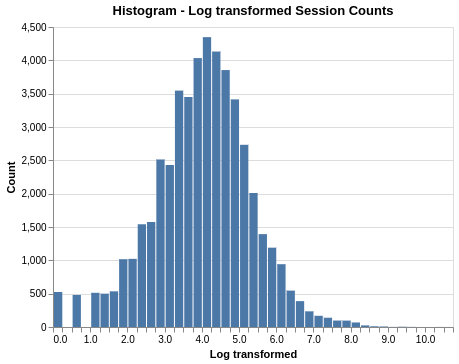

In [59]:
temp = np.log(df['unacast_session_count']).to_frame()

alt.Chart(temp).mark_bar().encode(
    alt.X("unacast_session_count:Q", bin=alt.Bin(step=0.25),title="Log transformed"),
    y=alt.Y('count()', title="Count")).properties(
    title='Histogram - Log transformed Session Counts'
)

In [60]:
m = temp['unacast_session_count'].mean()
sd = temp['unacast_session_count'].std()
print("mean: ", round(m,2), "standard deviation: ", round(sd,2))

mean:  4.0 standard deviation:  1.33


In [33]:
temp = df.loc[:,["external_id","unacast_session_count","month","year"]]
temp.head()

external_id  unacast_session_count  month  year
0     1900203                   78.0      3  2019
1     1900203                  111.0      6  2018
2     1900203                  110.0      8  2018
3  MR00101775                   10.0      1  2019
4  MR00101775                   11.0      8  2019

In [42]:
auto_corr_df = temp.pivot_table(index = ["year","month"],columns='external_id', values='unacast_session_count').dropna( axis=1)

In [43]:
auto_corr_df[1:].head()

external_id  01a78f56-5cc9-4309-8676-057933848570  \
year month                                          
2018 3                                       37.0   
     4                                       13.0   
     5                                       50.0   
     6                                       12.0   
     7                                       33.0   

external_id  04e045a9-1bf5-49a1-ab93-ffbe2d65cf94  \
year month                                          
2018 3                                        3.0   
     4                                        8.0   
     5                                       11.0   
     6                                       15.0   
     7                                        2.0   

external_id  0556b417-31b6-447f-9a54-0a5dc2da869e  \
year month                                          
2018 3                                      112.0   
     4                                      167.0   
     5                                      120.0   
     6                                      216.0   
     7                                      148.0   

external_id  079334b2-842a-4f69-848d-977001584db8  \
year month                                          
2018 3                                       40.0   
     4                                       41.0   
     5                                       78.0   
     6                                       53.0   
     7                                       57.0   

external_id  080b28ec-60df-4b33-980c-ebfe48c9602d  \
year month                                          
2018 3                                       62.0   
     4                                       58.0   
     5                                       49.0   
     6                                       64.0   
     7                                       24.0   

external_id  09030aee-77c1-4f11-b5f9-2e0a2a496136  \
year month                                          
2018 3                                       16.0   
     4                                       32.0   
     5                                       71.0   
     6                                       50.0   
     7                                       31.0   

external_id  0a11541e-75ac-4a2b-9517-b237810d2a10  \
year month                                          
2018 3                                       83.0   
     4                                       99.0   
     5                                      166.0   
     6                                      135.0   
     7                                       77.0   

external_id  0b091a15-5238-4008-8474-2c3ad58973b9  \
year month                                          
2018 3                                       52.0   
     4                                      120.0   
     5                                      123.0   
     6                                      197.0   
     7                                      201.0   

external_id  0b16ce2a-c262-4690-9616-5f576e2e36e1  \
year month                                          
2018 3                                      207.0   
     4                                      500.0   
     5                                      366.0   
     6                                      475.0   
     7                                      459.0   

external_id  0d566423-d7e2-4af2-9597-17d2990ed491  ...  \
year month                                         ...   
2018 3                                       53.0  ...   
     4                                       72.0  ...   
     5                                       73.0  ...   
     6                                      112.0  ...   
     7                                      150.0  ...   

external_id  f06f977d-16e8-45b9-a5b6-22af6d4a53b7  \
year month                                          
2018 3                                        9.0   
     4                                       47.0   
     5                           

In [54]:
lags = ["one","two","three","four","five","six","seven","eight","nine","ten","eleven","twelve"]

In [63]:
for  i in range(12):
    lags[i] = list()
    
for j in range(1,13):
    for i in auto_corr_df.columns.tolist():
        lags[j-1].append(auto_corr_df[i].autocorr(lag = j))

In [66]:
corr_d = dict()
for i in range(12):
    corr_d[str(i+1)] = lags[i]

In [72]:
temp = pd.DataFrame(data=corr_d)#.mean(axis=1)
temp.head()

1         2         3         4         5         6         7  \
0  0.585697  0.444873  0.454859  0.357932 -0.067186 -0.120132  0.097613   
1  0.390887 -0.169843 -0.142854  0.147524  0.530176  0.410941 -0.082979   
2  0.307092  0.234296  0.319719 -0.070384  0.367964  0.425398  0.306710   
3  0.491003  0.109364  0.074745  0.166238  0.307777  0.213012  0.021597   
4  0.430273  0.313149  0.043552 -0.160635 -0.197861 -0.627477 -0.352626   

          8         9        10        11        12  
0  0.029800  0.029828  0.268395  0.081592  0.535247  
1 -0.318064  0.427345  0.590370  0.320310 -0.376783  
2  0.335595 -0.298782 -0.414809  0.225365  0.120453  
3 -0.006573  0.425978  0.572432  0.160049 -0.250512  
4 -0.244671 -0.016977  0.116881  0.158052  0.858864

In [74]:
temp.columns[1]

'2'

In [83]:
charts = []
for i in range(1,13):
    charts.append(alt.Chart(temp).mark_bar().encode(
    alt.X(str(i)+":Q", bin=alt.Bin(step=0.025),title="lag of "+str(i)),
    y=alt.Y('count()', title="Count")).properties(
    title='Histogram - Auto correlation distribution over playgrounds'
))
#alt.vconcat(*charts)


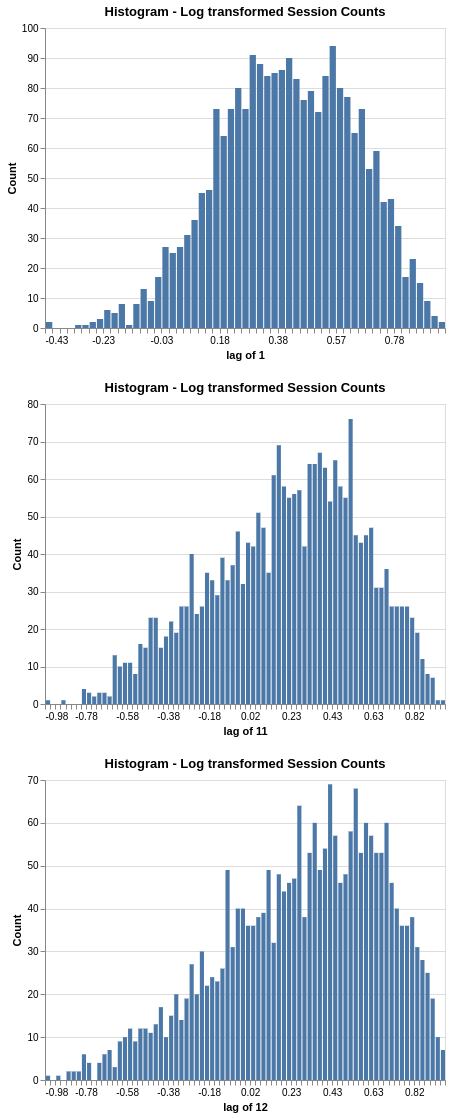

In [85]:
charts[0] & charts[10] &charts[11]

In [31]:
biba_pp(df)

external_id  month  year  B20004e10  B11016e1  B12001e12  B20004e11  \
0         1900203      3  2019      51111      1868        688          0   
1         1900203      6  2018      51111      1868        688          0   
2         1900203      8  2018      51111      1868        688          0   
3      MR00101775      1  2019      45484      2613        980      30417   
4      MR00101775      8  2019      45484      2613        980      30417   
...           ...    ...   ...        ...       ...        ...        ...   
50115  MR00101116      4  2019      84079      2295        361     135721   
50116  FM00171280      2  2018      37473      2460       1097      20307   
50117  FM00167991      7  2018      48462      2005        772      62037   
50118  MR00098241      6  2019      40571      2104        700          0   
50119  MR00098241      9  2019      40571      2104        700          0   

       B19125e1  B12001e13  B23008e22  ...  monthly_accessible  \
0         78934       1342          0  ...                 0.0   
1         78934       1342          0  ...                 0.0   
2         78934       1342          0  ...                 0.0   
3         45578       1097         66  ...                 0.0   
4         45578       1097         66  ...                 0.0   
...         ...        ...        ...  ...                 ...   
50115    145595       1965          7  ...                 0.0   
50116     46094       1052         65  ...                 0.0   
50117     93603       1443         42  ...                 0.0   
50118     36340        834        308  ...                 0.0   
50119     36340        834        308  ...                 0.0   

       monthly_condition  monthly_allages  monthly_Saturday  monthly_Friday  \
0                    0.0              0.0               0.0             0.0   
1                    0.0              0.0               0.0             0.0   
2                    0.0              0.0               0.0             0.0   
3                    0.0              0.0               0.0             0.0   
4                    0.0              0.0               0.0             0.0   
...                  ...              ...               ...             ...   
50115                0.0              0.0               0.0             0.0   
50116                0.0              0.0               0.0             0.0   
50117                0.0              0.0               0.0             0.0   
50118                0.0              0.0               0.0             0.0   
50119                0.0              0.0               0.0             0.0   

       monthly_Thursday  monthly_Sunday  monthly_Tuesday  monthly_Monday  \
0                   0.0             0.0              0.0             0.0   
1                   0.0             0.0              0.0             0.0   
2                   0.0             0.0              0.0             0.0   
3                   0.0             0.0              0.0             0.0   
4                   0.0             0.0              0.0             0.0   
...                 ...             ...              ...             ...   
50115               0.0             0.0              0.0             0.0   
50116               0.0             0.0              0.0             0.0   
50117               0.0             0.0              0.0             0.0   
50118               0.0             0.0              0.0             0.0   
50119               0.0             0.0              0.0             0.0   

       monthly_Wednesday  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
...                  ...  
50115                0.0  
50116                0.0  
50117                0.0  
50118                0.0  
50119                0.0  

[50120 rows x 861 columns]

In [32]:
preprocess_neighbour(df)

external_id  month  year  monthly_number_of_sessions  \
0         1900203      3  2019                           0   
1         1900203      6  2018                           0   
2         1900203      8  2018                           0   
3      MR00101775      1  2019                           0   
4      MR00101775      8  2019                           0   
...           ...    ...   ...                         ...   
50115  MR00101116      4  2019                           0   
50116  FM00171280      2  2018                           0   
50117  FM00167991      7  2018                           0   
50118  MR00098241      6  2019                           0   
50119  MR00098241      9  2019                           0   

       monthly_unique_sessions  monthly_repeated_sessions  \
0                            0                          0   
1                            0                          0   
2                            0                          0   
3                            0                          0   
4                            0                          0   
...                        ...                        ...   
50115                        0                          0   
50116                        0                          0   
50117                        0                          0   
50118                        0                          0   
50119                        0                          0   

       monthly_avg_length_of_session  monthly_avg_light_activity  \
0                                0.0                         0.0   
1                                0.0                         0.0   
2                                0.0                         0.0   
3                                0.0                         0.0   
4                                0.0                         0.0   
...                              ...                         ...   
50115                            0.0                         0.0   
50116                            0.0                         0.0   
50117                            0.0                         0.0   
50118                            0.0                         0.0   
50119                            0.0                         0.0   

       monthly_avg_moderate_activity  monthly_avg_vigorous_activity  ...  \
0                                0.0                            0.0  ...   
1                                0.0                            0.0  ...   
2                                0.0                            0.0  ...   
3                                0.0                            0.0  ...   
4                                0.0                            0.0  ...   
...                              ...                            ...  ...   
50115                            0.0                            0.0  ...   
50116                            0.0                            0.0  ...   
50117                            0.0                            0.0  ...   
50118                            0.0                            0.0  ...   
50119                            0.0                            0.0  ...   

       avg_wind_9_10  avg_wind_10_11  avg_wind_11_12  avg_wind_12_above  \
0                0.0             0.0             0.0                0.0   
1                0.0             0.0             0.0                0.0   
2                0.0             0.0             0.0                0.0   
3                0.0             0.0             0.0                0.0   
4                0.0             0.0             0.0                0.0   
...              ...             ...             ...                ...   
50115            0.0             0.0             0.0                0.0   
50116            0.0             0.0             0.0                0.0   
50117            0.0             0.0             0.0                0.0   
50118            0.0             0.0            

In [33]:
preprocess_weather(df)

external_id  month    year  monthly_number_of_sessions  \
0         1900203    3.0  2019.0                         0.0   
1         1900203    6.0  2018.0                         0.0   
2         1900203    8.0  2018.0                         0.0   
3      MR00101775    1.0  2019.0                         0.0   
4      MR00101775    8.0  2019.0                         0.0   
...           ...    ...     ...                         ...   
50115  MR00101116    4.0  2019.0                         0.0   
50116  FM00171280    2.0  2018.0                         0.0   
50117  FM00167991    7.0  2018.0                         0.0   
50118  MR00098241    6.0  2019.0                         0.0   
50119  MR00098241    9.0  2019.0                         0.0   

       monthly_unique_sessions  monthly_repeated_sessions  \
0                          0.0                        0.0   
1                          0.0                        0.0   
2                          0.0                        0.0   
3                          0.0                        0.0   
4                          0.0                        0.0   
...                        ...                        ...   
50115                      0.0                        0.0   
50116                      0.0                        0.0   
50117                      0.0                        0.0   
50118                      0.0                        0.0   
50119                      0.0                        0.0   

       monthly_avg_length_of_session  monthly_avg_light_activity  \
0                                0.0                         0.0   
1                                0.0                         0.0   
2                                0.0                         0.0   
3                                0.0                         0.0   
4                                0.0                         0.0   
...                              ...                         ...   
50115                            0.0                         0.0   
50116                            0.0                         0.0   
50117                            0.0                         0.0   
50118                            0.0                         0.0   
50119                            0.0                         0.0   

       monthly_avg_moderate_activity  monthly_avg_vigorous_activity  ...  \
0                                0.0                            0.0  ...   
1                                0.0                            0.0  ...   
2                                0.0                            0.0  ...   
3                                0.0                            0.0  ...   
4                                0.0                            0.0  ...   
...                              ...                            ...  ...   
50115                            0.0                            0.0  ...   
50116                            0.0                            0.0  ...   
50117                            0.0                            0.0  ...   
50118                            0.0                            0.0  ...   
50119                            0.0                            0.0  ...   

       avg_wind_12_above  perfect_days  unacast_session_count     hpi  \
0                    0.0           0.0                   78.0  323.61   
1                    0.0           4.0                  111.0  323.61   
2                    0.0           2.0                  110.0  323.61   
3                    0.0           0.0                   10.0  110.38   
4                    0.0           0.0                   11.0  110.38   
...                  ...           ...                    ...     ...   
50115                0.0           5.0                   30.0  237.35   
50116                0.0           0.0                   24.0  170.72   
50117                0.0           0.0                   45.0  515.12   
50118                0.0           5.0      

In [14]:
# drop 44 columns
df2.shape

(50114, 819)

In [17]:
df3 = biba_pp(df2)

TypeError: eval() arg 1 must be a string, bytes or code object

In [1]:
# Tried running overall PCA, requires dealing with nulls

# pca_all = PCA()
# pca_all.fit(df.drop(labels=['external_id','unacast_session_count'],axis=1).select_dtypes(include=[np.number]))

In [5]:
null_rate = (df.isna().sum(axis=0)/df.shape[0]).to_frame().rename(columns={0: "Null_rate"})

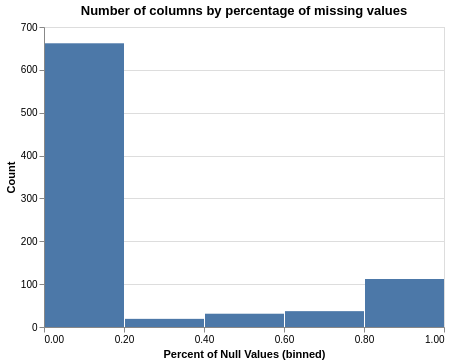

In [8]:
alt.Chart(null_rate).mark_bar().encode(
    alt.X("Null_rate:Q", bin=alt.Bin(maxbins=5),title="Percent of Null Values (binned)"),
    y=alt.Y('count()', title="Count")).properties(
    title='Number of columns by percentage of missing values'
)

In [45]:
(null_rate < 0.2).sum()

Null_rate    662
dtype: int64

In [46]:
(null_rate < 0.1).sum()

Null_rate    656
dtype: int64

In [51]:
((null_rate < 0.2)*(null_rate < 0.1)).sum()

/home/tani/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Null_rate    656
dtype: int64

In [6]:

vals = [0.2,0.4,0.6,0.8,1]

lst = [(null_rate < 0.2).sum()[0]]
for i in range(len(vals)-1):
    a = ((null_rate > vals[i])*(null_rate <= vals[i+1])).sum()
    lst.append(a[0])
    
print(lst, sum(lst))

[662, 19, 31, 37, 112] 861


/home/tani/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [8]:
grouped_df = df.groupby(by="external_id")

In [28]:
grouped_df.std().mean().sort_values(ascending=False).to_frame().rename(columns={0: "Standard_Deviation"}).dropna()#.query("Standard_Deviation > 0")

Standard_Deviation
monthly_avg_length_of_session       156569.109949
monthly_avg_light_activity           53890.132010
monthly_avg_moderate_activity        35520.582851
total_mentions_across_state          23681.143066
monthly_avg_vigorous_activity        10091.983834
...                                           ...
ice_cream                                0.000000
hotel                                    0.000000
healthcare                               0.000000
hairdresser_or_beauty                    0.000000
B11001e6                                 0.000000

[830 rows x 1 columns]

Taking the internal playground standard deviation for each column and averaging across all playgrounds, only 173 values are not 0.

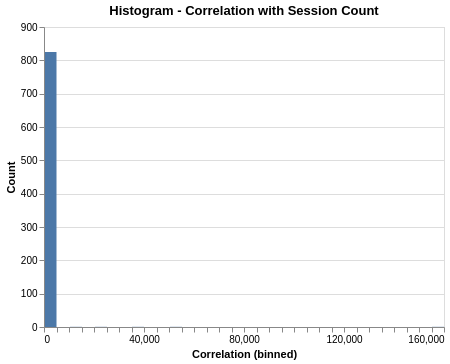

In [24]:
alt.Chart(grouped_df.std().mean().sort_values(ascending=False).to_frame().rename(columns={0: "Standard Deviation"}).dropna()).mark_bar().encode(
    alt.X("Standard Deviation:Q", bin=alt.Bin(maxbins=50),title="Correlation (binned)"),
    y=alt.Y('count()', title="Count")).properties(
    title='Histogram - Correlation with Session Count'
)

In [14]:
km=KMeans(n_clusters = i)

### Clustering

In [3]:
def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

In [5]:
df = pd.read_csv('../data/train_data.zip')

In [8]:
clust_df = clean_categorical(preprocessing_na(df))

In [22]:
expl = clust_df.drop('unacast_session_count',axis=1)

In [9]:
unacast = clust_df[['unacast_session_count']]

In [49]:
unacast_log = StandardScaler().fit_transform(np.log(unacast).fillna(0))

/home/tani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


ValueError: Input contains infinity or a value too large for dtype('float64').

In [47]:
norm_unacast = StandardScaler().fit_transform(unacast)

In [15]:
kme = KMeans(init='k-means++', n_clusters=50, n_init=2).fit(norm_unacast)

In [41]:
inert = []
num = [i for i in range(1,11)]
for i in num:
    kme = KMeans(init='k-means++', n_clusters=i, n_init=5).fit(norm_unacast)
    inert.append(kme.inertia_)

In [42]:
avg_inert = [inert[i]/num[i] for i in range(len(inert))]

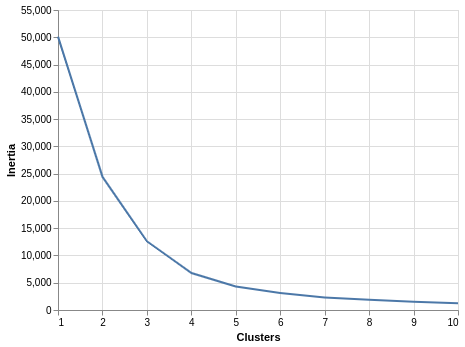

In [43]:
alt.Chart(pd.DataFrame(data={"Clusters":num, "Inertia":inert, "Average Inertia": avg_inert})).mark_line().encode(
    x='Clusters:Q',
    y='Inertia'
)

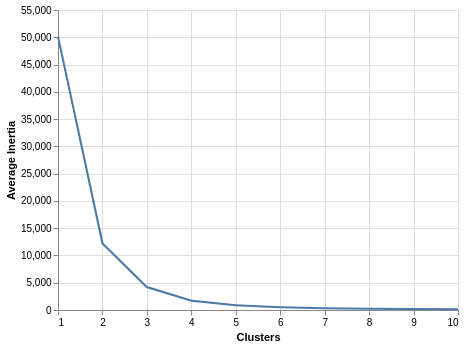

In [44]:
alt.Chart(pd.DataFrame(data={"Clusters":num, "Inertia":inert, "Average Inertia": avg_inert})).mark_line().encode(
    x='Clusters:Q',
    y='Average Inertia:Q'
)

In [ ]:
inert = []
num = [i for i in range(1,11)]
for i in num:
    kme = KMeans(init='k-means++', n_clusters=i, n_init=5).fit(norm_unacast)
    inert.append(kme.inertia_)

In [ ]:
dbscan = DBSCAN(eps=0.1, min_samples=10).fit(norm_unacast)

In [7]:
#Download libraries
import re
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# The two main functions are `preprocessing_na()` do impute NaNs 
# and delete some columns with a very low fill rate, 
# `clean_categorical()` to use OHE on categorical variables.


def dict_to_columns_df(col, key, val):
    """
    This function takes a dataframe column which is in the
    form of list of dictionaries and creates a dataframe
    from the keys of the in the inner list of dictionaries 
    e.g. "[{'key': A, 'val': 1}, {'key': B, 'val': 2}]"
    
    Parameters
    ----------------
    col : DataFrame Series, the columns whose values are the in the format
    of a list of dictionaries.
    
    key : the keys in the inner dictionary from which column names are to be extracted
    
    val : the keys in the inner dictionary from which values in the column needs to
    be extracted
    
    
    Returns
    ----------------
    DataFrame
        With the new columns created from the keys of the inner dictionary
        
    """
    key_list = set()
    i=0
    # getting all the new column names
    while i < len(col):
        if type(col[i]) != float:
            dic_list = eval(col[i]) #converting col value from string to list
            for dic in range(len(dic_list)):
                if re.match('[a-zA-Z]', dic_list[dic][str(key)][0]): #removing spanish names
                    key_list.add("monthly_"+dic_list[dic][str(key)])
        i+=1
    
    all_cols_dict = defaultdict(list)
    
    i = 0
    while i < len(col):
        if type(col[i]) != float:
            dic_list = eval(col[i]) #converting col value from string to list

            for col_names in list(key_list):
                flag = 0 #to check if a column name exists in the dictionary
                for dic in range(len(dic_list)):
                    if dic_list[dic][str(key)] == col_names[8:]: #getting values from the inner dictionary matching the key
                        all_cols_dict[col_names].append(dic_list[dic][str(val)]) #putting inner dict values to new default dict
                        flag = 1
                        break
                
                if flag==0:
                    all_cols_dict[col_names].append(None)

        else:
            for col_names in list(key_list):
                all_cols_dict[col_names].append(None)

        i+=1
    new_cols_df = pd.DataFrame(all_cols_dict)
    
    # checking new df has same number of columns as given column
    if new_cols_df.shape[0] == col.shape[0]:
        return new_cols_df
    else:
        print("Column dimensions don't match")
        
def biba_pp(full_data):  
    
    """
    Performs the pre-processing of the columns for the biba data
    
    Parameters
    ---------------
    
    full_data : DataFrame, with no operations done on the biba columns
    
    Returns
    ---------------
    DataFrame
        with processed biba columns
    
    """
    biba_games_df = pd.DataFrame()
    biba_games_df = pd.concat([full_data.loc[:, 'monthly_number_of_sessions':'distance_to_nearest_bus_stop'],
                               full_data.loc[:, 'days_since_first_sess':'historic_snow']], axis = 1)
                               
    #extracting categorical features
    categorical_features = biba_games_df.loc[:, biba_games_df.dtypes == "object"]
     
    # creating cols from list of dictionaries
    monthly_survey_df = dict_to_columns_df(categorical_features['monthly_survey'], 'question', 'avg_answer')
    monthly_weekday_counts_df = dict_to_columns_df(categorical_features['monthly_weekday_counts'], 'weekday', 'count')
    
    biba_games_df = pd.concat([biba_games_df, monthly_survey_df, monthly_weekday_counts_df], axis = 1)
    
    #dropping categorical features
    biba_games_df = biba_games_df.drop(columns = list(categorical_features.columns))
    
    #dropping historic hours with low fill rate
    numerical_cols_to_remove = ['historic_hour_0', 'historic_hour_23', 'historic_hour_22', 'historic_hour_21',
                                'historic_hour_7','historic_hour_6','historic_hour_5','historic_hour_4', 
                                'historic_hour_3','historic_hour_2','historic_hour_1', 'MonthYear']
    
    biba_games_df = biba_games_df.drop(columns = numerical_cols_to_remove)
    
    impute_biba_games_df = biba_games_df.fillna(0)
    
    #removing the previous columns in the input data
    cols_to_drop = list(full_data.loc[:, 'monthly_number_of_sessions': 'distance_to_nearest_bus_stop'].columns) +\
                   list(full_data.loc[:, 'days_since_first_sess' : 'historic_snow'].columns)
    
    full_data = full_data.drop(columns = cols_to_drop)
    
    #adding processed columns
    full_data = pd.concat([full_data, impute_biba_games_df], axis = 1)
    
    return full_data
    
def preprocess_neighbour(input_data):
    """
    Given the original dataframe, preprocess the columns
    related to locale information (`city` to
    `houses_per_sq_km`). Drop columns with >30%
    NaN values and replace remaining NaN values with 0.
    Parameters
    ----------
    input_data : pandas.core.frame.DataFrame
    Returns
    -------
    output_data : pandas.core.frame.DataFrame
    """
    
    df_neighbour = input_data.loc[:, 'city':'houses_per_sq_km']
    df_neighbour.drop(columns=['climate'])
    missing = df_neighbour.isna()
    
    # Count number of missing values for each column
    num_missing = missing.sum().sort_values(ascending=False)
    
    # Calculate proportion of missing values for each column
    prop_missing = num_missing / input_data.shape[0]
    
    # Create a list of columns with >30% of values missing
    to_drop = prop_missing[prop_missing > 0.3].index.to_list()
    
    # Add `country` to the list since all playgrounds are in the U.S.
    # Add `city` and `county` since lat. and long. should take care of them
    to_drop.append('country')
    to_drop.append('city')
    to_drop.append('county')
    
    # Drop columns with names in list
    output_data = input_data.drop(to_drop, axis=1)
    
    # Fill in remaining NaN values in locale-related columns with 0
    to_impute = prop_missing[(0 < prop_missing) & (prop_missing <= 0.3)].index.to_list()
    to_impute.remove('city')
    to_impute.remove('county')
    output_data[to_impute] = output_data[to_impute].fillna(0)
    output_data['climate'] = input_data['climate']

    return output_data
    
def preprocess_weather(input_data):
    """
    Given the original dataframe, preprocess the columns
    related to weather information (`Democrats_08_Votes` to
    the end + `climate`). Impute NaN of `Number_of_holidays` 
    by using the values the we have for the same month,
    impute NaN of `Green_2016` by using values found online, or 0, 
    and replace remaining NaN values with 0.
    
    Parameters
    ----------
    input_data : pandas.core.frame.DataFrame
    
    Returns
    -------
    output_data : pandas.core.frame.DataFrame
    
    """
    
    df_weather = input_data.loc[:, 'Democrats_08_Votes':]
    df_weather['state'] = input_data['state']
    df_weather['climate'] = input_data['climate']
    df_weather['external_id'] = input_data['external_id']
    df_weather['month'] = input_data['month']
    df_weather['year'] = input_data['year']
    
    
    #fill up NaNs for `Number_of_holidays` column
    #I sorted the values so that the values are ordered by time, and the NaNs are at the end of each time period
    df_weather = df_weather.sort_values(['month', 'year', 'Number_of_holidays'])
    df_weather['Number_of_holidays'] = df_weather['Number_of_holidays'].fillna(method='ffill')
    
    #fill up NaNs for the `Green_2016` column
    #I only found values for Alaska and North Carolina, so I just put 0 for the other states
    df_weather['Green_2016'] = np.where(
     df_weather['state'] == 'Alaska', 5735, 
         np.where(
            df_weather['state'] == 'North Carolina', 12105,  
             np.where(
                df_weather['Green_2016'].isnull(), 0, df_weather['Green_2016'] 
             )
         )
    )
    
    df_weather['climate'] = df_weather['climate'].fillna(df_weather['climate'].mode()[0])
    
    #Substitute every remaining NaNs by 0
    df_weather = df_weather.fillna(value=0)
    
    output_data = input_data.copy()
    output_data.loc[:, 'Democrats_08_Votes':] = df_weather.loc[:, 'Democrats_08_Votes':]
    output_data['climate'] = df_weather['climate']
    
    #Tests
    
    #Check that there are no missing values in the `Number_of_holidays` column
    if not output_data['Number_of_holidays'].isnull().sum() == 0:
        raise Error('There should not be NaNs in the Number_of_holidays column')
    
    #Check that every month has only one value for the `Number_of_holiday` column
    number_of_error = 0
    for month in range(12):
        for year in [2018, 2019]:
            sub_df = output_data[(output_data['month'] == month+1) & (output_data['year'] == year)]
            if len(sub_df['Number_of_holidays'].unique()) > 1:
                number_of_error += 1 
    if not number_of_error == 0:
        raise Error('Every month should have the same value for Number_of_holidays')
    
    
               
    return output_data
    
def clean_categorical(input_data, to_drop=['income_class', 'density_class', 'climate']):
    """
    Given the original dataframe, uses One-Hot-Encoding to encode the categorical variables
    
    
    Parameters
    ----------
    input_data : pandas.core.frame.DataFrame
    to_drop : list
        The list of the categorical variables on which we want to apply OHE
    
    Returns
    -------
    output_data : pandas.core.frame.DataFrame
    
    """
    
    output_data = input_data.copy()

    #Apply One-Hot-Encoding to each one of the categorical variable
    for col in to_drop:
        ohe = OneHotEncoder(sparse=False, dtype=int)
        sub_df = pd.DataFrame(ohe.fit_transform(input_data[[col]]), columns=ohe.categories_[0])
        output_data = pd.concat((output_data, sub_df), axis=1)
    #Drop the columns for which we used OHE
    output_data.drop(columns = to_drop, inplace=True)
    
    return output_data

def preprocessing_na(input_data):
    """
    Gather all the preprocessing function from the 3 different parts of the data
    
    
    Parameters
    ----------
    input_data : pandas.core.frame.DataFrame
    
    Returns
    -------
    output_data : pandas.core.frame.DataFrame
    
    """
    data_1 = biba_pp(input_data)
    data_2 = preprocess_neighbour(data_1)
    output_data = preprocess_weather(data_2)
    return output_data

